In [2]:
from apo_holo_structure_stats.pipeline.utils.json import read_jsons_with_seqs_in
a = 'hovno'

In [3]:
import sys
import json
import pandas as pd

## Filter structures

In [4]:
import sys

from apo_holo_structure_stats.pipeline.utils.json import read_jsons_with_seqs_in

filtered__json_folder = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/meta_output/filtered.json_shard.d/*'
df = read_jsons_with_seqs_in(filtered__json_folder)
df = df.drop(columns='sequence')


loading filtered.json_shard24: 100/100
concatenating...
done.


In [5]:
df.describe(include='all')


,uniprotkb_id,pdb_code,uniprot_group_size,path,chain_id,is_holo
count,275659,275659,275659.000000,275659,275659,275659
unique,31511,119076,NaN,125155,2036,2
top,Q79791,3j3q,NaN,../input/pdb_structs88/3j3q.cif.gz,A,True
freq,2582,1356,NaN,1356,114944,171911
mean,NaN,NaN,142.688535,NaN,NaN,NaN
std,NaN,NaN,338.779873,NaN,NaN,NaN
min,NaN,NaN,2.000000,NaN,NaN,NaN
25%,NaN,NaN,8.000000,NaN,NaN,NaN
50%,NaN,NaN,26.000000,NaN,NaN,NaN
75%,NaN,NaN,107.000000,NaN,NaN,NaN


Compute upper bound of count of a-h pairs (for each uniprot group)

In [6]:
by_unp = df.groupby('uniprotkb_id')
holos_by_group = by_unp['is_holo'].sum()
apos_by_group = by_unp['is_holo'].count() - holos_by_group

ub_pairs_by_group = (apos_by_group * holos_by_group).rename('upper_bound_on_pairs')
print('ub on all pairs:', ub_pairs_by_group.sum())
ub_pairs_by_group.describe()


ub on all pairs: 2973238


count     31511.000000
mean         94.355558
std        3287.218990
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      395527.000000
Name: upper_bound_on_pairs, dtype: float64

clip: 10 ub_pairs: 61109 ecdf:  0.8654
clip: 100 ub_pairs: 228713 ecdf:  0.9653
clip: 1000 ub_pairs: 616695 ecdf:  0.9929
clip: inf ub_pairs: 2973238 ecdf:  0.0000


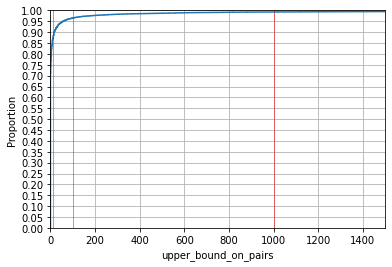

In [7]:
from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(ub_pairs_by_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 1000, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(ub_pairs_by_group.to_numpy()), np.linspace(0, 1, len(ub_pairs_by_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'ub_pairs:', ub_pairs_by_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')

plt.show()


## Make Pairs LCS

In [4]:
import pandas as pd
import json
#
# potential_pairs = pd.read_json('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs', )
# print(len(potential_pairs))
#


In [5]:
json_filename = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs'
with open(json_filename) as f:
    potential_pairs = pd.json_normalize(json.load(f))


In [10]:
potential_pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,2.973238e+06,2.973238e+06,2.973238e+06,2.973238e+06,2.973238e+06,2.973238e+06
mean,1.622273e+02,4.757007e+01,5.342030e+01,8.702955e+01,3.326011e+01,5.376944e+01
std,1.546087e+02,1.131088e+02,1.137240e+02,1.633831e+02,8.893563e+01,1.259912e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.270000e+02,2.000000e+00,2.000000e+00,3.500000e+01,0.000000e+00,0.000000e+00
75%,2.210000e+02,4.700000e+01,6.900000e+01,1.030000e+02,3.300000e+01,5.900000e+01
max,4.620000e+03,2.843000e+03,4.221000e+03,2.083000e+03,2.083000e+03,1.618000e+03


In [6]:
print(len(potential_pairs))
pairs = potential_pairs[potential_pairs['lcs_result.mismatches'] == 0]
print(len(pairs))

2973238
1132444


In [15]:
len(pairs[pairs['lcs_result.length'] < 50])
# todo I can remove those from results
# and the shortest give errors in run_analyses (if all are unobserved - 0 residues), but that's ok..

1258

In [12]:
pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,1.132444e+06,1.132444e+06,1.132444e+06,1132444.0,1132444.0,1132444.0
mean,2.191686e+02,3.523263e+00,6.990543e+00,0.0,0.0,0.0
std,1.394397e+02,2.338920e+01,3.943674e+01,0.0,0.0,0.0
min,3.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
25%,1.290000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
50%,1.690000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
75%,3.060000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
max,4.620000e+03,2.327000e+03,2.987000e+03,0.0,0.0,0.0


In [13]:
# todo join with unp ids and find out the distribution in groups.
# if same as potential pairs or not.
chains = pd.read_json('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_groups.json')
pairs = pairs.merge(chains.set_index(['pdb_code', 'chain_id']), left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)

In [14]:
pairs.columns

Index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo',
       'lcs_result.length', 'lcs_result.i1', 'lcs_result.i2',
       'lcs_result.mismatches', 'lcs_result.leading_mismatches',
       'lcs_result.trailing_mismatches', 'uniprotkb_id', 'uniprot_group_size'],
      dtype='object')

In [15]:
pairs_per_group = pairs.groupby('uniprotkb_id').size()
pairs_per_group.describe()

count      6893.000000
mean        164.521399
std        3239.701243
min           1.000000
25%           2.000000
50%           6.000000
75%          18.000000
max      167995.000000
dtype: float64

Z hlediska cachování modelů by mě zajímalo, kolikrát maximálně (a průměrně) v párech figuruje jedna struktura. (A všechno jsou ekvivalence/je to tranzitivní? Nutně nemusí, jde-li o jiné úseky třeba, ale většinou jo, je-li tam nějaký překryv, je to implikováno, ale? - počítám a1, a2 k h1 a pak vezmeš h2, která je na a1, je taky k a2? Za předpokladu, že mají LCS(a1, h1) a LCS(a1, h2) nějaký překryv.

No každopádně -- udělej groupby struktura sizes... (ani nemusíš myslim podle uniprotu)

Dalo by se to dělat takto
- načíst vždy 5 apo a k nim vystridat 5 holo, dalsich 5 holo,...
    - 25 párů a pouze 5 načítání -> 5x reduction in parsing structures time

A když jsme u zrychlování - nemusím načítat nebo aspoň držet v paměti celou strukturu, když mi stačí chain (nebo ty set_of_residues)
- samozřejmě biopython má reference i nahoru, takže bych ten chain musel disconnectnout, pokud chci pracovat s residues objekty (a ne treba jenom c alpha coords)
    - na to c alpha coords bych si mohl koneckonců napsat parser sám,... ale to už ne (potřebuju všechny atomy, pro interface, ne jen calpha..)
    - no ale dalo by se to udelat megaefektivne - jenom coords v numpy a treba indices AAs/ atom typy
    - asi musim prijmout, ze to neni efektivni a pouzivam to...
    - kazdopadne, chain bych disconnectnout mohl?

In [16]:
from typing import List


def total_when_clipped(upper_clips: List[float], group_counts, ax=None, color='r', label='counts'):

    def find_nearest_idx(array, value):
        return (np.abs(array - value)).argmin()

    ecdf_y, ecdf_x = np.sort(group_counts.to_numpy()), np.linspace(0, 1, len(group_counts), endpoint=False)

    for clip in upper_clips:
        if ax:
            ax.axvline(clip, c=color, lw=0.5)
        ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
        print('clip:', clip, f'{label}:', group_counts.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')



# apo
count    36452.000000
mean        31.110666
std         66.606124
min          1.000000
25%          2.000000
50%          6.000000
75%         22.000000
max        613.000000
dtype: float64
clip: 5 total pairs cached: 133423 ecdf:  0.4595
clip: 10 total pairs cached: 213401 ecdf:  0.6136
clip: 50 total pairs cached: 539586 ecdf:  0.8423
clip: inf total pairs cached: 1134046 ecdf:  0.0000
# holo
count    58464.000000
mean        19.397339
std         73.000867
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        749.000000
dtype: float64
clip: 5 total pairs cached: 193817 ecdf:  0.5793
clip: 10 total pairs cached: 284642 ecdf:  0.7518
clip: 50 total pairs cached: 567494 ecdf:  0.9239
clip: inf total pairs cached: 1134046 ecdf:  0.0000


Text(0.5, 1.0, '# pairs per structure')

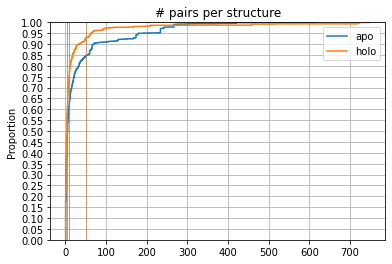

In [17]:
colors = iter(sns.color_palette())
for a_or_h in ('apo', 'holo'):
    print('#', a_or_h)
    pairs_per_apo = pairs.groupby([f'pdb_code_{a_or_h}', f'chain_id_{a_or_h}']).size()
    print(pairs_per_apo.describe())
    ax = sns.ecdfplot(pairs_per_apo, label=a_or_h)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    total_when_clipped([5, 10, 50, np.inf], pairs_per_apo, ax=ax, color=next(colors), label='total pairs cached')
plt.grid()
ax.legend()
plt.title('# pairs per structure')



count    36452.000000
mean        31.110666
std         66.606124
min          1.000000
25%          2.000000
50%          6.000000
75%         22.000000
max        613.000000
dtype: float64


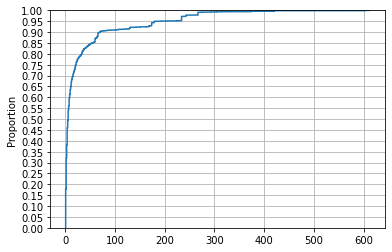

In [18]:
pairs_per_apo = pairs.groupby(['pdb_code_apo', 'chain_id_apo']).size()
print(pairs_per_apo.describe())
ax = sns.ecdfplot(pairs_per_apo)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.grid()

clip: 10 pairs: 41116 ecdf:  0.6308
clip: 100 pairs: 131669 ecdf:  0.9198
clip: 200 pairs: 174086 ecdf:  0.9514
clip: 1700 pairs: 356659 ecdf:  0.9903
clip: inf pairs: 1134046 ecdf:  0.0000


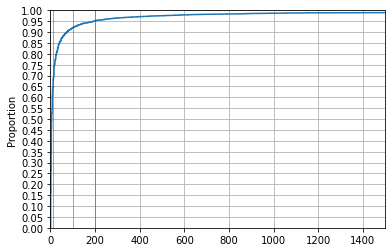

In [19]:

from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(pairs_per_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 200, 1700, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(pairs_per_group.to_numpy()), np.linspace(0, 1, len(pairs_per_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'pairs:', pairs_per_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')


[(0.0, 30.0)]

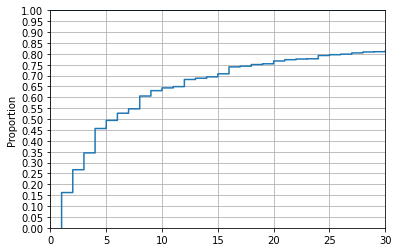

In [20]:
# musel jsem to zkopirovat, nevim, jak to zobrazit znova s jinym xlim
ax = sns.ecdfplot(pairs_per_group)
plt.axhline(np.max(ax.lines[0].get_ydata()))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set(xlim=(0, 30))

## Run analyses

---
### Just debugging memory usage

In [21]:
potential_pairs.memory_usage()
# 120 MB plus data (strings and lcs_results), how can that be 4 GB? When the json is 600 MB...
# string 53 bytes ~ 50 bytes (empty 49)
# lcs result 6 ints -> 48 bytes -> 3M * 0.1 kB = 0.3 GB, 40 bytes empty tuple
#     88 bytes if tuple
# but it's a dict! with non-interned strings :(((( wtf..

Index                                  128
pdb_code_apo                      23785904
chain_id_apo                      23785904
pdb_code_holo                     23785904
chain_id_holo                     23785904
lcs_result.length                 23785904
lcs_result.i1                     23785904
lcs_result.i2                     23785904
lcs_result.mismatches             23785904
lcs_result.leading_mismatches     23785904
lcs_result.trailing_mismatches    23785904
dtype: int64

In [22]:
# print(potential_pairs.describe())
pairs = potential_pairs[potential_pairs.mismatches == 0]
print(len(pairs))
pairs.describe()

AttributeError: 'DataFrame' object has no attribute 'mismatches'

In [ ]:
import gc
gc.collect()

In [ ]:
potential_pairs.columns


In [ ]:
df = pd.json_normalize('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs')

In [ ]:
from collections import defaultdict

json_filename = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs'
with open(json_filename) as f:
    # items = []
    #
    # def intern_dict_keys(obj):
    #     interned_keys_obj = {}
    #     for k, v in obj.items():
    #         # k = sys.intern(k)
    #         interned_keys_obj[k] = v
    #
    #     global items
    #     items.append(interned_keys_obj)
    #     if len(items) == 10:
    #         items_by_len = defaultdict(list)
    #         for i in items:
    #             items_by_len[len(i)].append(i)
    #
    #         print(list(items_by_len.keys()))
    #         for items in items_by_len.values():
    #             for corr_keys in zip(*items):
    #                 for i in range(len(corr_keys)-1):
    #                     print(corr_keys[i] is corr_keys[i+1])
    #
    #     return interned_keys_obj
    # careful not to keep reference to loaded json
    potential_pairs = pd.json_normalize(json.load(f))


In [ ]:
print(potential_pairs.memory_usage())


In [ ]:
gc.collect()


In [ ]:
import gc
potential_pairs = potential_pairs.drop(columns='chain_id_holo')
potential_pairs = potential_pairs.drop(columns='chain_id_apo')


In [ ]:
print(potential_pairs.memory_usage())

In [ ]:
potential_pairs= []
gc.collect()
